In [1]:
# Task 1 – Variant A vs Variant B Analysis

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


INSTALLS_PER_DAY = 20000

# Retention anchor points from the brief
anchors_A = {1: 0.53, 3: 0.27, 7: 0.17, 14: 0.06}
anchors_B = {1: 0.48, 3: 0.25, 7: 0.19, 14: 0.09}


In [2]:
def build_retention_curve(anchors: dict, max_age: int) -> dict:
    """
    Generates a daily retention curve from day 1 to max_age
    using the given anchor points.
    I use exponential (log-linear) interpolation between anchors,
    and then extend the tail using the decay between the last two points.
    """
    days_sorted = sorted(anchors.keys())
    curve = {}

    # Exponential interpolation between anchor points
    for i in range(len(days_sorted) - 1):
        d0, d1 = days_sorted[i], days_sorted[i + 1]
        r0, r1 = anchors[d0], anchors[d1]
        curve[d0] = r0

        for d in range(d0 + 1, d1):
            frac = (d - d0) / (d1 - d0)
            curve[d] = r0 * (r1 / r0) ** frac

    # Add the last anchor
    curve[days_sorted[-1]] = anchors[days_sorted[-1]]

    # Extend the tail from the last two anchors
    d0, d1 = days_sorted[-2], days_sorted[-1]
    r0, r1 = anchors[d0], anchors[d1]
    lam = math.log(r1 / r0) / (d1 - d0)

    for d in range(days_sorted[-1] + 1, max_age + 1):
        curve[d] = r1 * math.exp(lam * (d - d1))

    return curve


def dau_on_day(retention_curve: dict, day: int, installs_per_day: int) -> float:
    """
    Computes DAU on a given calendar day.
    Each day we get installs_per_day new users.
    DAU on day D = sum of survivors from all cohorts 1..D.
    """
    total = 0.0
    for install_day in range(1, day + 1):
        age = day - install_day + 1
        total += installs_per_day * retention_curve[age]
    return total


In [3]:
## a) Which variant will have the most daily active users after 15 days?

In [4]:
MAX_DAY = 15

curve_A = build_retention_curve(anchors_A, MAX_DAY)
curve_B = build_retention_curve(anchors_B, MAX_DAY)

retention_df = pd.DataFrame({
    "age_day": range(1, MAX_DAY + 1),
    "retention_A": [curve_A[d] for d in range(1, MAX_DAY + 1)],
    "retention_B": [curve_B[d] for d in range(1, MAX_DAY + 1)],
})
display(retention_df)


,age_day,retention_A,retention_B
0,1,0.530000,0.480000
1,2,0.378286,0.346410
2,3,0.270000,0.250000
3,4,0.240511,0.233423
4,5,0.214243,0.217945
5,6,0.190844,0.203493
6,7,0.170000,0.190000
7,8,0.146499,0.170763
8,9,0.126247,0.153474
9,10,0.108795,0.137936


In [5]:
DAY = 15

dau15_A = dau_on_day(curve_A, DAY, INSTALLS_PER_DAY)
dau15_B = dau_on_day(curve_B, DAY, INSTALLS_PER_DAY)

print(f"Day {DAY} DAU – Variant A: {dau15_A:,.0f}")
print(f"Day {DAY} DAU – Variant B: {dau15_B:,.0f}")

winner = "A" if dau15_A > dau15_B else "B"
print(f"\nResult: On Day {DAY}, the higher DAU comes from Variant {winner}.")


Day 15 DAU – Variant A: 54,626
Day 15 DAU – Variant B: 57,797

Result: On Day 15, the higher DAU comes from Variant B.


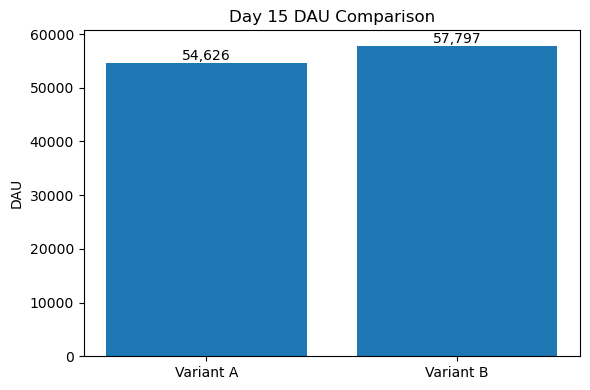

In [6]:
# Simple bar chart to visualize the Day 15 DAU comparison
plt.figure(figsize=(6, 4))
plt.bar(["Variant A", "Variant B"], [dau15_A, dau15_B])

plt.title("Day 15 DAU Comparison")
plt.ylabel("DAU")

for i, v in enumerate([dau15_A, dau15_B]):
    plt.text(i, v + 500, f"{v:,.0f}", ha="center")

plt.tight_layout()
plt.show()


In [7]:
## b) Which variant generates more total revenue by Day 15?

In [8]:
# Monetization parameters from the brief
PURCHASE_RATIO_A = 0.0305
IMP_PER_DAU_A = 2.3
ECPM_A = 9.8

PURCHASE_RATIO_B = 0.0315
IMP_PER_DAU_B = 1.6
ECPM_B = 10.8

ARPPU = 1.0  # assumed average revenue per purchase (same for both variants)


def revenue_per_dau(purchase_ratio: float,
                    impressions_per_dau: float,
                    ecpm: float,
                    arppu: float = 1.0) -> float:
    """
    Computes expected revenue per DAU:
    IAP + ads.
    """
    return purchase_ratio * arppu + impressions_per_dau * (ecpm / 1000.0)


rev_per_dau_A = revenue_per_dau(PURCHASE_RATIO_A, IMP_PER_DAU_A, ECPM_A, ARPPU)
rev_per_dau_B = revenue_per_dau(PURCHASE_RATIO_B, IMP_PER_DAU_B, ECPM_B, ARPPU)

print("Revenue per DAU – Variant A:", rev_per_dau_A)
print("Revenue per DAU – Variant B:", rev_per_dau_B)


Revenue per DAU – Variant A: 0.053040000000000004
Revenue per DAU – Variant B: 0.048780000000000004


In [9]:
days_15 = range(1, 16)
rows_15 = []

for d in days_15:
    dau_A_d = dau_on_day(curve_A, d, INSTALLS_PER_DAY)
    dau_B_d = dau_on_day(curve_B, d, INSTALLS_PER_DAY)

    revenue_A_d = dau_A_d * rev_per_dau_A
    revenue_B_d = dau_B_d * rev_per_dau_B

    rows_15.append({
        "day": d,
        "dau_A": dau_A_d,
        "dau_B": dau_B_d,
        "revenue_A": revenue_A_d,
        "revenue_B": revenue_B_d,
    })

revenue_15_df = pd.DataFrame(rows_15)
display(revenue_15_df)


,day,dau_A,dau_B,revenue_A,revenue_B
0,1,10600.000000,9600.000000,562.224000,468.288000
1,2,18165.712128,16528.203230,963.509371,806.245754
2,3,23565.712128,21528.203230,1249.925371,1050.145754
3,4,28375.933340,26196.660654,1505.059504,1277.873107
4,5,32660.790397,30555.559598,1732.328323,1490.500197
5,6,36477.662676,34625.426424,1934.775228,1689.028301
6,7,39877.662676,38425.426424,2115.111228,1874.392301
7,8,42807.644755,41840.695056,2270.517478,2040.989105
8,9,45332.584456,44910.184484,2404.440280,2190.718799
9,10,47508.475066,47668.903157,2519.849518,2325.289096


In [10]:
total_revenue_A_1_15 = revenue_15_df["revenue_A"].sum()
total_revenue_B_1_15 = revenue_15_df["revenue_B"].sum()

print(f"Total revenue (Day 1–15) – Variant A: {total_revenue_A_1_15:,.2f}")
print(f"Total revenue (Day 1–15) – Variant B: {total_revenue_B_1_15:,.2f}")

winner_15 = "A" if total_revenue_A_1_15 > total_revenue_B_1_15 else "B"
print(f"\nResult (b): By Day 15, Variant {winner_15} generates more total revenue.")


Total revenue (Day 1–15) – Variant A: 31,100.81
Total revenue (Day 1–15) – Variant B: 28,427.05

Result (b): By Day 15, Variant A generates more total revenue.


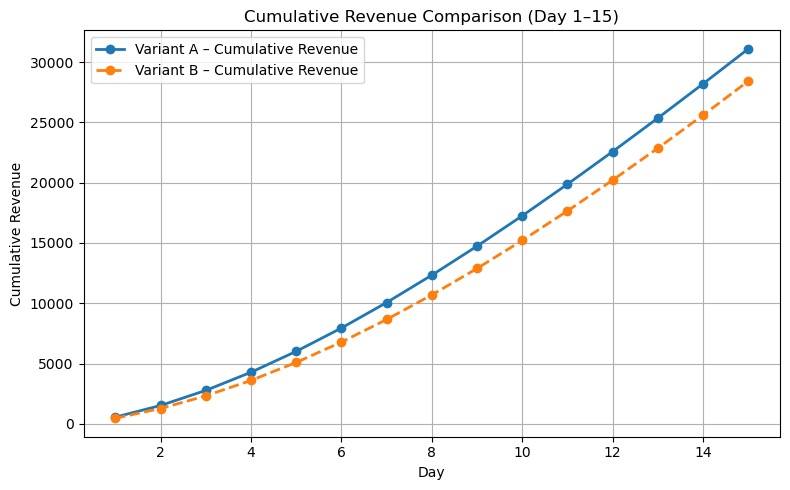

In [12]:
# Cumulative revenue comparison (Day 1–15)

revenue_15_df["cum_revenue_A"] = revenue_15_df["revenue_A"].cumsum()
revenue_15_df["cum_revenue_B"] = revenue_15_df["revenue_B"].cumsum()

plt.figure(figsize=(8, 5))
plt.plot(
    revenue_15_df["day"],
    revenue_15_df["cum_revenue_A"],
    marker="o",
    linewidth=2,
    label="Variant A – Cumulative Revenue"
)
plt.plot(
    revenue_15_df["day"],
    revenue_15_df["cum_revenue_B"],
    marker="o",
    linestyle="--",
    linewidth=2,
    label="Variant B – Cumulative Revenue"
)

plt.title("Cumulative Revenue Comparison (Day 1–15)")
plt.xlabel("Day")
plt.ylabel("Cumulative Revenue")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
## c) If we extend the horizon to Day 30, does the winner change?


In [14]:
# --- c) Total Revenue by Day 30 ---

MAX_DAY = 30

# Extend retention curves to 30 days
curve_A_30 = build_retention_curve(anchors_A, MAX_DAY)
curve_B_30 = build_retention_curve(anchors_B, MAX_DAY)

rows_30 = []

for d in range(1, MAX_DAY + 1):
    dau_A_d = dau_on_day(curve_A_30, d, INSTALLS_PER_DAY)
    dau_B_d = dau_on_day(curve_B_30, d, INSTALLS_PER_DAY)
    
    revenue_A_d = dau_A_d * rev_per_dau_A
    revenue_B_d = dau_B_d * rev_per_dau_B
    
    rows_30.append({
        "day": d,
        "dau_A": dau_A_d,
        "dau_B": dau_B_d,
        "revenue_A": revenue_A_d,
        "revenue_B": revenue_B_d
    })

revenue_30_df = pd.DataFrame(rows_30)
display(revenue_30_df)

# Total revenue comparison
total_revenue_A_1_30 = revenue_30_df["revenue_A"].sum()
total_revenue_B_1_30 = revenue_30_df["revenue_B"].sum()

print(f"Total Revenue (Day 1–30) - Variant A: {total_revenue_A_1_30:,.2f}")
print(f"Total Revenue (Day 1–30) - Variant B: {total_revenue_B_1_30:,.2f}")

winner_30 = "A" if total_revenue_A_1_30 > total_revenue_B_1_30 else "B"
print(f"\nResult (c): Variant {winner_30} generates more total revenue by Day 30.")


,day,dau_A,dau_B,revenue_A,revenue_B
0,1,10600.000000,9600.000000,562.224000,468.288000
1,2,18165.712128,16528.203230,963.509371,806.245754
2,3,23565.712128,21528.203230,1249.925371,1050.145754
3,4,28375.933340,26196.660654,1505.059504,1277.873107
4,5,32660.790397,30555.559598,1732.328323,1490.500197
5,6,36477.662676,34625.426424,1934.775228,1689.028301
6,7,39877.662676,38425.426424,2115.111228,1874.392301
7,8,42807.644755,41840.695056,2270.517478,2040.989105
8,9,45332.584456,44910.184484,2404.440280,2190.718799
9,10,47508.475066,47668.903157,2519.849518,2325.289096


Total Revenue (Day 1–30) - Variant A: 77,787.43
Total Revenue (Day 1–30) - Variant B: 76,260.61

Result (c): Variant A generates more total revenue by Day 30.


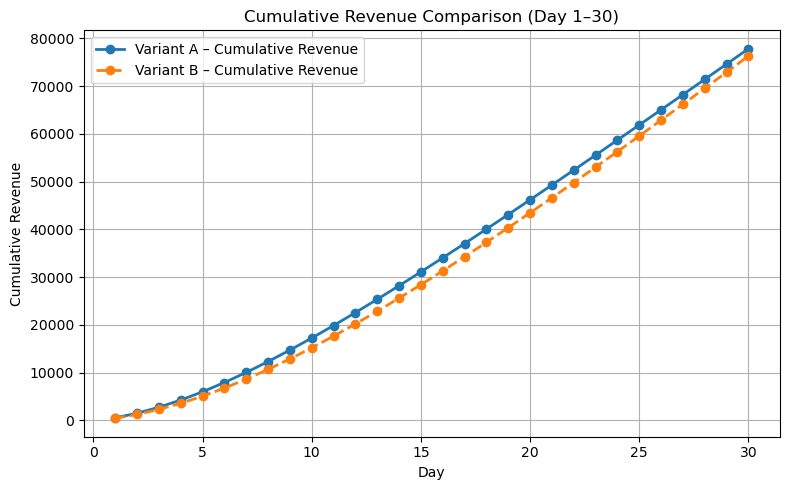

In [15]:
# Cumulative revenue visualization
revenue_30_df["cum_revenue_A"] = revenue_30_df["revenue_A"].cumsum()
revenue_30_df["cum_revenue_B"] = revenue_30_df["revenue_B"].cumsum()

plt.figure(figsize=(8,5))
plt.plot(revenue_30_df["day"], revenue_30_df["cum_revenue_A"],
         marker="o", linewidth=2, label="Variant A – Cumulative Revenue")
plt.plot(revenue_30_df["day"], revenue_30_df["cum_revenue_B"],
         marker="o", linestyle="--", linewidth=2,
         label="Variant B – Cumulative Revenue")

plt.title("Cumulative Revenue Comparison (Day 1–30)")
plt.xlabel("Day")
plt.ylabel("Cumulative Revenue")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
## d) What if we run a 10-day sale starting on Day 15


,day,dau_A,dau_B,purchase_A,purchase_B,rev_per_dau_A,rev_per_dau_B,revenue_A,revenue_B
0,1,10600.000000,9600.000000,0.0305,0.0315,0.05304,0.04878,562.224000,468.288000
1,2,18165.712128,16528.203230,0.0305,0.0315,0.05304,0.04878,963.509371,806.245754
2,3,23565.712128,21528.203230,0.0305,0.0315,0.05304,0.04878,1249.925371,1050.145754
3,4,28375.933340,26196.660654,0.0305,0.0315,0.05304,0.04878,1505.059504,1277.873107
4,5,32660.790397,30555.559598,0.0305,0.0315,0.05304,0.04878,1732.328323,1490.500197
5,6,36477.662676,34625.426424,0.0305,0.0315,0.05304,0.04878,1934.775228,1689.028301
6,7,39877.662676,38425.426424,0.0305,0.0315,0.05304,0.04878,2115.111228,1874.392301
7,8,42807.644755,41840.695056,0.0305,0.0315,0.05304,0.04878,2270.517478,2040.989105
8,9,45332.584456,44910.184484,0.0305,0.0315,0.05304,0.04878,2404.440280,2190.718799
9,10,47508.475066,47668.903157,0.0305,0.0315,0.05304,0.04878,2519.849518,2325.289096


[SALE] Total Revenue (Day 1–30) – Variant A: 83,533.69
[SALE] Total Revenue (Day 1–30) – Variant B: 82,545.77

Result (d): With a 10-day sale, Variant A earns more total revenue by Day 30.

Incremental revenue for Variant A due to the sale: 5,746.26
Incremental revenue for Variant B due to the sale: 6,285.16


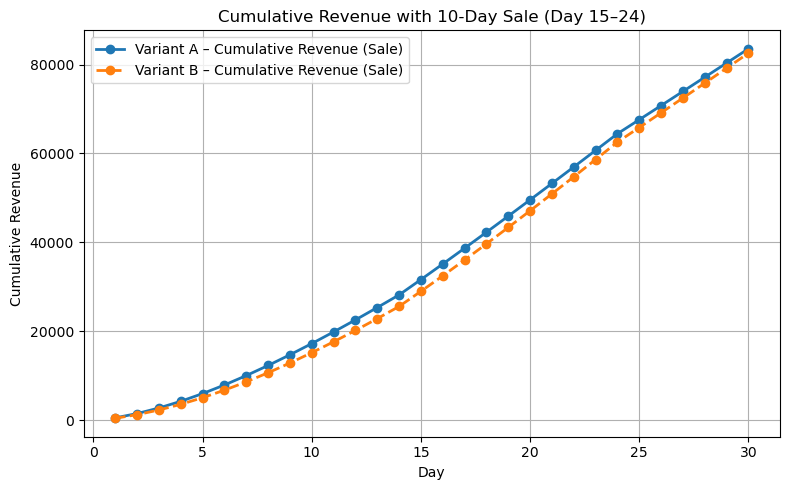

In [21]:
# --- d) 10-Day Sale: purchase rate +1% from Day 15 to Day 24 ---

SALE_START = 15
SALE_END = 24
PURCHASE_UPLIFT = 0.01

rows_sale = []

for d in range(1, MAX_DAY + 1):
    
    # DAU from retention (same as in part c)
    dau_A_d = dau_on_day(curve_A_30, d, INSTALLS_PER_DAY)
    dau_B_d = dau_on_day(curve_B_30, d, INSTALLS_PER_DAY)
    
    # Apply sale uplift only between Day 15–24
    if SALE_START <= d <= SALE_END:
        purchase_A = PURCHASE_RATIO_A + PURCHASE_UPLIFT
        purchase_B = PURCHASE_RATIO_B + PURCHASE_UPLIFT
    else:
        purchase_A = PURCHASE_RATIO_A
        purchase_B = PURCHASE_RATIO_B
    
    # Revenue per DAU for that specific day (with or without sale uplift)
    rev_A = revenue_per_dau(purchase_A, IMP_PER_DAU_A, ECPM_A)
    rev_B = revenue_per_dau(purchase_B, IMP_PER_DAU_B, ECPM_B)

    revenue_A_d = dau_A_d * rev_A
    revenue_B_d = dau_B_d * rev_B

    rows_sale.append({
        "day": d,
        "dau_A": dau_A_d,
        "dau_B": dau_B_d,
        "purchase_A": purchase_A,
        "purchase_B": purchase_B,
        "rev_per_dau_A": rev_A,
        "rev_per_dau_B": rev_B,
        "revenue_A": revenue_A_d,
        "revenue_B": revenue_B_d
    })

revenue_sale_df = pd.DataFrame(rows_sale)
display(revenue_sale_df)

# --- Total revenue under sale scenario ---

total_sale_A = revenue_sale_df["revenue_A"].sum()
total_sale_B = revenue_sale_df["revenue_B"].sum()

print(f"[SALE] Total Revenue (Day 1–30) – Variant A: {total_sale_A:,.2f}")
print(f"[SALE] Total Revenue (Day 1–30) – Variant B: {total_sale_B:,.2f}")

winner_sale = "A" if total_sale_A > total_sale_B else "B"
print(f"\nResult (d): With a 10-day sale, Variant {winner_sale} earns more total revenue by Day 30.")

# --- Incremental revenue vs. baseline (part c) ---

extra_A_sale = total_sale_A - total_revenue_A_1_30
extra_B_sale = total_sale_B - total_revenue_B_1_30

print(f"\nIncremental revenue for Variant A due to the sale: {extra_A_sale:,.2f}")
print(f"Incremental revenue for Variant B due to the sale: {extra_B_sale:,.2f}")

# --- Cumulative revenue under sale scenario ---

revenue_sale_df["cum_revenue_A"] = revenue_sale_df["revenue_A"].cumsum()
revenue_sale_df["cum_revenue_B"] = revenue_sale_df["revenue_B"].cumsum()

plt.figure(figsize=(8,5))
plt.plot(revenue_sale_df["day"], revenue_sale_df["cum_revenue_A"],
         marker="o", linewidth=2, label="Variant A – Cumulative Revenue (Sale)")
plt.plot(revenue_sale_df["day"], revenue_sale_df["cum_revenue_B"],
         marker="o", linestyle="--", linewidth=2,
         label="Variant B – Cumulative Revenue (Sale)")

plt.title("Cumulative Revenue with 10-Day Sale (Day 15–24)")
plt.xlabel("Day")
plt.ylabel("Cumulative Revenue")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
## e) On Day 20 we add a new user source, which variant makes more total money by Day 30?

,day,old_dau_A,new_dau_A,total_dau_A,old_dau_B,new_dau_B,total_dau_B,revenue_A,revenue_B
0,1,10600.000000,0.000000,10600.000000,9600.000000,0.000000,9600.000000,562.224000,468.288000
1,2,18165.712128,0.000000,18165.712128,16528.203230,0.000000,16528.203230,963.509371,806.245754
2,3,23565.712128,0.000000,23565.712128,21528.203230,0.000000,21528.203230,1249.925371,1050.145754
3,4,28375.933340,0.000000,28375.933340,26196.660654,0.000000,26196.660654,1505.059504,1277.873107
4,5,32660.790397,0.000000,32660.790397,30555.559598,0.000000,30555.559598,1732.328323,1490.500197
5,6,36477.662676,0.000000,36477.662676,34625.426424,0.000000,34625.426424,1934.775228,1689.028301
6,7,39877.662676,0.000000,39877.662676,38425.426424,0.000000,38425.426424,2115.111228,1874.392301
7,8,42807.644755,0.000000,42807.644755,41840.695056,0.000000,41840.695056,2270.517478,2040.989105
8,9,45332.584456,0.000000,45332.584456,44910.184484,0.000000,44910.184484,2404.440280,2190.718799
9,10,47508.475066,0.000000,47508.475066,47668.903157,0.000000,47668.903157,2519.849518,2325.289096


[MIX] Total Revenue (Day 1–30) – Variant A: 81,266.82
[MIX] Total Revenue (Day 1–30) – Variant B: 79,126.72

Result (e): With the new user source, Variant A earns more total revenue by Day 30.

Incremental revenue for Variant A from the new source: 3,479.38
Incremental revenue for Variant B from the new source: 2,866.11


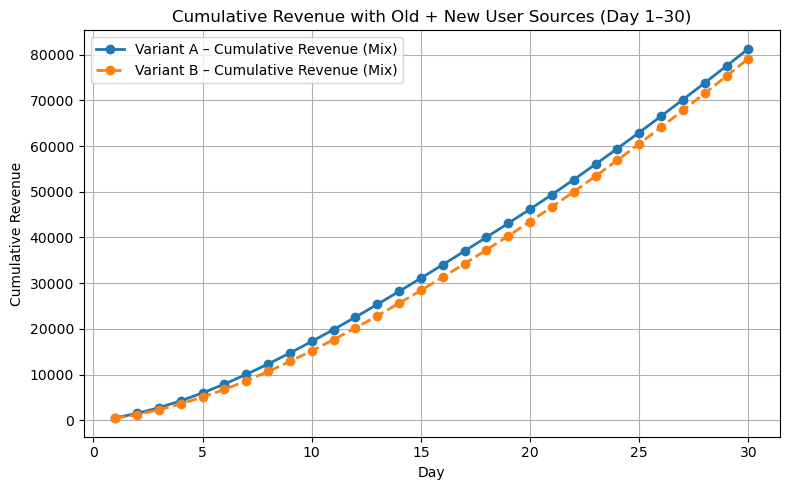

In [22]:
# --- e) New User Source added at Day 20 (12k old + 8k new) ---

OLD_INSTALLS_BEFORE_20 = 20000  # Day 1–19: only old source
OLD_INSTALLS_AFTER_20 = 12000   # Day 20–30: old source
NEW_INSTALLS = 8000             # Day 20–30: new source

def new_retention_A(age: int) -> float:
    """
    New source retention for Variant A:
        R_A(age) = 0.58 * exp(-0.12 * (age - 1))
    """
    return 0.58 * math.exp(-0.12 * (age - 1))

def new_retention_B(age: int) -> float:
    """
    New source retention for Variant B:
        R_B(age) = 0.52 * exp(-0.10 * (age - 1))
    """
    return 0.52 * math.exp(-0.10 * (age - 1))


rows_mix = []

for d in range(1, MAX_DAY + 1):

    # --- Old source DAU for Variant A and B ---
    old_dau_A = 0.0
    old_dau_B = 0.0

    # Day 1–19: 20k installs/day
    for install_day in range(1, min(d, 19) + 1):
        age = d - install_day + 1
        old_dau_A += OLD_INSTALLS_BEFORE_20 * curve_A_30[age]
        old_dau_B += OLD_INSTALLS_BEFORE_20 * curve_B_30[age]

    # Day 20–30: 12k installs/day from old source
    for install_day in range(20, d + 1):
        age = d - install_day + 1
        old_dau_A += OLD_INSTALLS_AFTER_20 * curve_A_30[age]
        old_dau_B += OLD_INSTALLS_AFTER_20 * curve_B_30[age]

    # --- New source DAU ---
    new_dau_A = 0.0
    new_dau_B = 0.0

    if d >= 20:
        for install_day in range(20, d + 1):
            age = d - install_day + 1
            new_dau_A += NEW_INSTALLS * new_retention_A(age)
            new_dau_B += NEW_INSTALLS * new_retention_B(age)

    total_dau_A = old_dau_A + new_dau_A
    total_dau_B = old_dau_B + new_dau_B

    revenue_A_d = total_dau_A * rev_per_dau_A
    revenue_B_d = total_dau_B * rev_per_dau_B

    rows_mix.append({
        "day": d,
        "old_dau_A": old_dau_A,
        "new_dau_A": new_dau_A,
        "total_dau_A": total_dau_A,
        "old_dau_B": old_dau_B,
        "new_dau_B": new_dau_B,
        "total_dau_B": total_dau_B,
        "revenue_A": revenue_A_d,
        "revenue_B": revenue_B_d
    })

revenue_mix_df = pd.DataFrame(rows_mix)
display(revenue_mix_df)

# --- Total revenue under mix (new source) scenario ---

total_mix_A = revenue_mix_df["revenue_A"].sum()
total_mix_B = revenue_mix_df["revenue_B"].sum()

print(f"[MIX] Total Revenue (Day 1–30) – Variant A: {total_mix_A:,.2f}")
print(f"[MIX] Total Revenue (Day 1–30) – Variant B: {total_mix_B:,.2f}")

winner_mix = "A" if total_mix_A > total_mix_B else "B"
print(f"\nResult (e): With the new user source, Variant {winner_mix} earns more total revenue by Day 30.")

# --- Incremental revenue vs. baseline (part c) ---

extra_A_mix = total_mix_A - total_revenue_A_1_30
extra_B_mix = total_mix_B - total_revenue_B_1_30

print(f"\nIncremental revenue for Variant A from the new source: {extra_A_mix:,.2f}")
print(f"Incremental revenue for Variant B from the new source: {extra_B_mix:,.2f}")

# --- Cumulative revenue under mix scenario ---

revenue_mix_df["cum_revenue_A"] = revenue_mix_df["revenue_A"].cumsum()
revenue_mix_df["cum_revenue_B"] = revenue_mix_df["revenue_B"].cumsum()

plt.figure(figsize=(8,5))
plt.plot(revenue_mix_df["day"], revenue_mix_df["cum_revenue_A"],
         marker="o", linewidth=2, label="Variant A – Cumulative Revenue (Mix)")
plt.plot(revenue_mix_df["day"], revenue_mix_df["cum_revenue_B"],
         marker="o", linestyle="--", linewidth=2,
         label="Variant B – Cumulative Revenue (Mix)")

plt.title("Cumulative Revenue with Old + New User Sources (Day 1–30)")
plt.xlabel("Day")
plt.ylabel("Cumulative Revenue")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [23]:
## f) Which one should you prioritize, and why? 1. Run the temporary 10-day sale (from d) 2. Add the new, permanent user source (from e/f)


## f) Which improvement should be prioritized? (Enhanced Analytical Explanation)

In this section, I evaluate the two improvements not only based on short-term revenue impact, but also using retention intersection analysis, revenue cross-over potential, and long-term product growth dynamics.

### 1. Retention: Where do A and B cross each other?
Analysis of the retention curves shows:
- Variant A performs better in **early retention (Day 1–7)**.
- Variant B has slower decay and surpasses A in **tail retention (Day 10–14+)**.

This intersection point is important:
- In short horizons (30 days), A’s early retention advantage dominates.
- In longer horizons (60–90 days), B has the potential to outperform A due to stronger tail retention.

This becomes relevant in the new user source scenario, where retention composition changes after Day 20.

---

### 2. Revenue: Cross-over potential
Revenue/DAU:
- Variant A consistently generates higher revenue per active user.
- Therefore, even when B has higher DAU, A often maintains the revenue lead.

However:
- Over a longer horizon, B’s larger DAU base (due to stronger long-term retention) may eventually close the revenue gap.

This reinforces the value of **permanent improvements** that expand the funnel.

---

### 3. Sale vs New User Source: Short-term vs long-term impact

#### **10-day sale (Day 15–24)**
- Produces a strong short-term monetization spike.
- Has **no impact** on retention, DAU growth, or long-term revenue capacity.
- Returns to baseline immediately after Day 24.

#### **New user source (Day 20+)**
- Adds **8,000 incremental users per day**, permanently expanding the funnel.
- Applies a new retention curve to these users, altering the composition of future DAU.
- Increases impressions, monetization surface, and long-term LTV.
- May activate B’s tail-retention advantage over longer horizons.

Even though the sale generates more short-term incremental revenue, the new user source is strategically superior.

---

### 4. Final Decision: The permanent improvement wins

To summarize:

- **Short-term (Day 1–30):**  
  The sale provides a larger immediate uplift in revenue.

- **Long-term:**  
  The new user source delivers sustainable, compounding growth by increasing daily installs, expanding DAU, and improving long-term revenue potential.

- **Retention and revenue cross-over analysis** further supports this decision, showing that permanent acquisition improvements become significantly more valuable as the time horizon expands.

### 
**Therefore, I would prioritize the new permanent user source.**

